In [2]:
!pip install kneed
import pandas as pd
import sklearn
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
#from yellowbrick.cluster import SilhouetteVisualizer
import matplotlib.pyplot as plt
from kneed import KneeLocator
import scipy.stats as stats


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
NTS_dummy = pd.read_csv('/content/drive/MyDrive/socio_pred/UKDA-5340-tab/NTS_v2.csv')
NTS_dummy.shape

(2445, 137)

In [4]:
# replace NA with zero
#na occurs for std of users with one trip, or count of users with no weekend trip
NTS_dummy = NTS_dummy.fillna(0)

In [5]:
mobility = NTS_dummy.iloc[:,38:]
socio = NTS_dummy.drop(columns = ['IndividualID','SurveyYear']).iloc[:,0:36]

In [6]:
socio_cols = {'age' : socio.columns[0:6],
'sex' : socio.columns[6:8],
'marital' : socio.columns[8:10],
'income': socio.columns[10:13],
'work': socio.columns[13:16],
'hhincome': socio.columns[16:19],
'hh_struc': socio.columns[19:25],
'hh_work': socio.columns[25:28],
'hh_socialclass': socio.columns[28:34],
'urban_rural': socio.columns[34:36]}

## K-means Clustering

In [7]:
#normalize
x = mobility
scaler = MinMaxScaler()
x = scaler.fit_transform(x)
#pca
#keep 85% of variance explained by selected components
pca = PCA(n_components=0.85)
principalComponents = pca.fit_transform(x)
pca.n_components_
#11 components are selected

10

For n_clusters = 2 The average silhouette_score is : 0.20917449418433
For n_clusters = 3 The average silhouette_score is : 0.21355966538604942
For n_clusters = 4 The average silhouette_score is : 0.17468546620891723
For n_clusters = 5 The average silhouette_score is : 0.16692001350256278
For n_clusters = 6 The average silhouette_score is : 0.16507830897619977
For n_clusters = 7 The average silhouette_score is : 0.16921417254442642
For n_clusters = 8 The average silhouette_score is : 0.17270198149699223
For n_clusters = 9 The average silhouette_score is : 0.16305839032478828
For n_clusters = 10 The average silhouette_score is : 0.16784789680626452
For n_clusters = 11 The average silhouette_score is : 0.16782829565915588
For n_clusters = 12 The average silhouette_score is : 0.17103453349914247
For n_clusters = 13 The average silhouette_score is : 0.16599178508348078
For n_clusters = 14 The average silhouette_score is : 0.16374571131288063
For n_clusters = 15 The average silhouette_score 

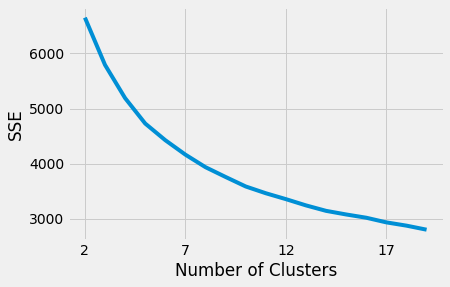

Number of clusters is: 8


In [9]:
# number of clusters
 
def elbow(pcs):

  kmeans_kwargs = {
      "init": "random",
      "n_init": 10,
      "max_iter": 300,
      "random_state": 42,
  }

  # A list holds the SSE values for each k
  sse = []
  #fig, ax = plt.subplots(10, 2, figsize=(15,16))

  max_cluster = min(20,pcs.shape[0])
  for k in range(2, max_cluster):
      kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
      kmeans.fit(pcs)
      cluster_labels = kmeans.fit_predict(pcs)
      silhouette_avg = silhouette_score(pcs, cluster_labels)
      print(
        "For n_clusters =",
        k,
        "The average silhouette_score is :",
        silhouette_avg,
    )
      sse.append(kmeans.inertia_)
      # q, mod = divmod(k, 2)
      # '''
      # Create SilhouetteVisualizer instance with KMeans instance
      # Fit the visualizer
      # '''
      # visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick', ax=ax[q-1][mod])
      # visualizer.fit(features)

  plt.style.use("fivethirtyeight")
  plt.plot(range(2, max_cluster), sse)
  plt.xticks(range(2, max_cluster,5))
  plt.xlabel("Number of Clusters")
  plt.ylabel("SSE")
  plt.show()

  kl = KneeLocator(
    range(2, max_cluster), sse, curve="convex", direction="decreasing"
  )
  print('Number of clusters is:',  kl.elbow)
  return 

elbow(principalComponents)

In [10]:
#kmeans function
def kplot(pcs,k):

  kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
  }

  kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
  kmeans.fit(pcs)
  cluster_labels = kmeans.fit_predict(pcs)
  df = pd.DataFrame(pcs)
  df['label'] = kmeans.labels_
  
  return df

In [11]:
pc_df = kplot(principalComponents,8)

In [12]:
pc_df.groupby('label').size()

label
0    501
1    278
2    283
3    579
4    374
5    236
6     99
7     95
dtype: int64

In [13]:
socio['label'] = pc_df['label']

## Statistical Test for clusters


In [14]:
def chi2stat(df,var):
  df = df.groupby('label').sum()[var]
  #for chi2 test, min freq should be at least 5
  var2 = (df>4).all()[(df>4).all()==True].index 
  
  chi2 = stats.chi2_contingency(df[var2])
  if len(var2)<2:
    print('Not enough data')
  print('P_value: ',chi2[1])
  return


In [15]:
vars = socio_cols.keys()

for v in vars:
  print(v)
  chi2stat(socio,socio_cols[v])
  print('-----')
  

age
P_value:  1.0287766489807455e-36
-----
sex
P_value:  1.279439514885214e-13
-----
marital
P_value:  0.0008835886289511929
-----
income
P_value:  5.195037571929372e-29
-----
work
P_value:  3.619376169834287e-66
-----
hhincome
P_value:  3.2089046116000462e-27
-----
hh_struc
P_value:  5.346355693551822e-12
-----
hh_work
P_value:  7.216282350223503e-42
-----
hh_socialclass
P_value:  1.1816241713696507e-41
-----
urban_rural
P_value:  0.007761321264146574
-----


All sociodemographic variables are significantly different among clusters

# COMPARE Sociodemographics among clusters

In [67]:
#AGE
# convert dummy to mean of band
tmp_df = pd.DataFrame()
tmp_df['age_band'] = socio[socio_cols['age']].idxmax(axis=1)

age_dict = {'Age_B04ID_4':	18.5, 
'Age_B04ID_5':	25,
'Age_B04ID_6':	35,
'Age_B04ID_7':	45,
'Age_B04ID_8':	55,
'Age_B04ID_9':	65}
for n in age_dict.keys():
  socio.loc[tmp_df["age_band"] == n, "AGE"] = age_dict[n]



In [83]:
socio[['AGE','label']].groupby('label').mean()

,AGE
label,
0,55.173653
1,45.266187
2,51.339223
3,46.219344
4,49.895722
5,53.264831
6,51.065657
7,45.110526


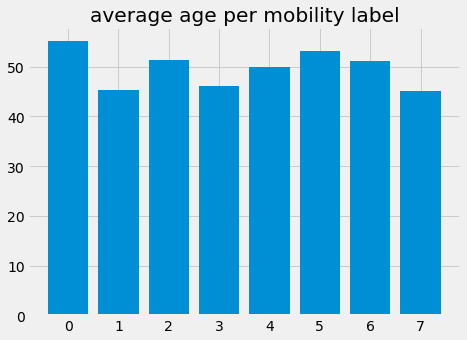

In [87]:
a = socio[['AGE','label']].groupby('label').mean()
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = a.index
var = a.AGE
ax.bar(labels,var)
ax.set_title('average age per mobility label')
plt.show()

In [76]:
socio[['AGE','label']].groupby('label').median()

,AGE
label,
0,65.0
1,45.0
2,55.0
3,45.0
4,55.0
5,55.0
6,55.0
7,45.0


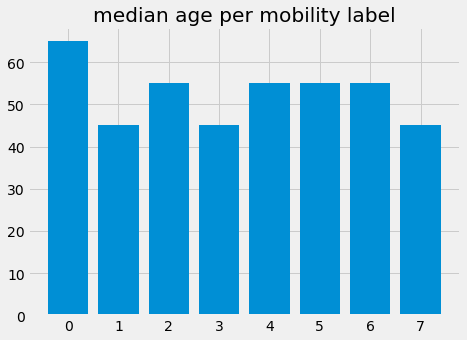

In [88]:
a = socio[['AGE','label']].groupby('label').median()
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = a.index
var = a.AGE
ax.bar(labels,var)
ax.set_title('median age per mobility label')
plt.show()

In [93]:
#income
# convert dummy to mean of band
tmp_df = pd.DataFrame()
tmp_df['income_band'] = socio[socio_cols['income']].idxmax(axis=1)

income_dict = {'IndIncome2002_B02ID_1':	12.5, 
'IndIncome2002_B02ID_2':	37.5,
'IndIncome2002_B02ID_3':	62.5}
for n in income_dict.keys():
  socio.loc[tmp_df["income_band"] == n, "INCOME"] = income_dict[n]

socio[['INCOME','label']].groupby('label').mean()


,INCOME
label,
0,21.382236
1,28.956835
2,21.510601
3,28.432642
4,31.751337
5,22.139831
6,26.641414
7,37.500000


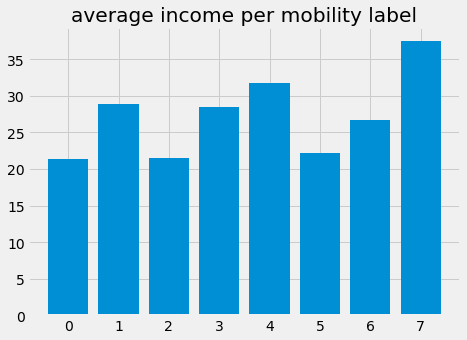

In [95]:
a = socio[['INCOME','label']].groupby('label').mean()
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = a.index
var = a.INCOME
ax.bar(labels,var)
ax.set_title('average income per mobility label')
plt.show()

In [94]:
socio[['INCOME','label']].groupby('label').median()


,INCOME
label,
0,12.5
1,37.5
2,12.5
3,12.5
4,37.5
5,12.5
6,12.5
7,37.5


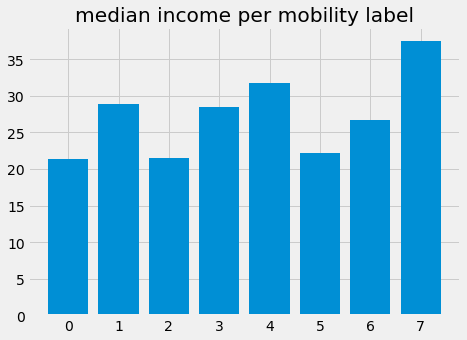

In [96]:
a = socio[['INCOME','label']].groupby('label').mean()
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = a.index
var = a.INCOME
ax.bar(labels,var)
ax.set_title('median income per mobility label')
plt.show()

In [123]:
def mrg(var):
  lst = list(socio_cols[var])
  lst.append('label')
  return socio[lst].groupby('label').sum()

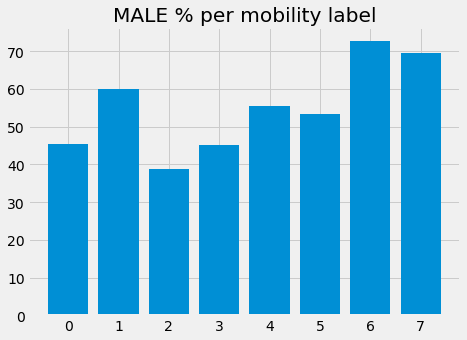

In [124]:
#GENDER
pops = mrg('sex').sum(axis=1)
perc = mrg('sex')['Sex_B01ID_1']/pops*100
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = perc.index
var = perc
ax.bar(labels,var)
ax.set_title('MALE % per mobility label')
plt.show()

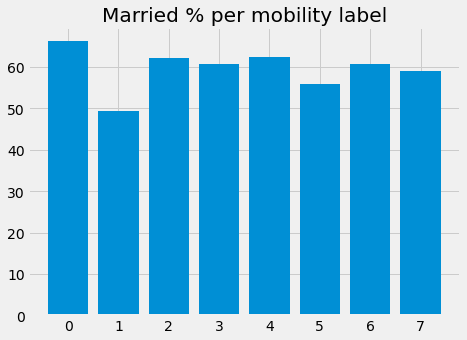

In [126]:
#marital
pops = mrg('marital').sum(axis=1)
perc = mrg('marital')['married']/pops*100
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = perc.index
var = perc
ax.bar(labels,var)
ax.set_title('Married % per mobility label')
plt.show()

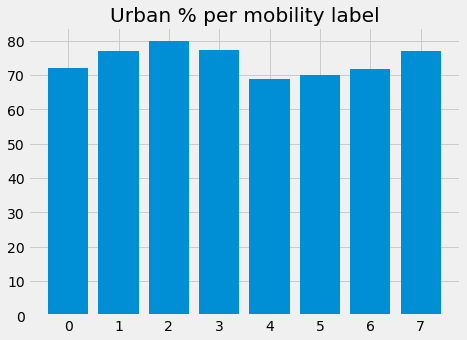

In [138]:
#urban rural
pops = mrg('urban_rural').sum(axis=1)
perc = mrg('urban_rural')['Settlement2011EW_B03ID_1']/pops*100
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = perc.index
var = perc
ax.bar(labels,var)
ax.set_title('Urban % per mobility label')
plt.show()

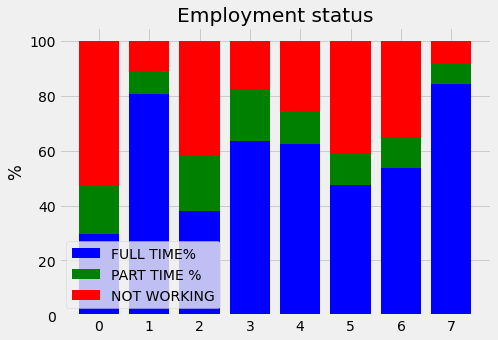

In [136]:
#work
pops = mrg('work').sum(axis=1)
full = mrg('work')['fulltime']/pops*100
part = mrg('work')['parttime']/pops*100
nowork = mrg('work')['not_working']/pops*100

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = full.index


ax.bar(labels, full, color='b')
ax.bar(labels, part,bottom=full, color='g')
ax.bar(labels, nowork,bottom=part+full, color='r')

ax.set_ylabel('%')
ax.set_title('Employment status')
ax.legend(labels=['FULL TIME%', 'PART TIME %', 'NOT WORKING'])
plt.show()

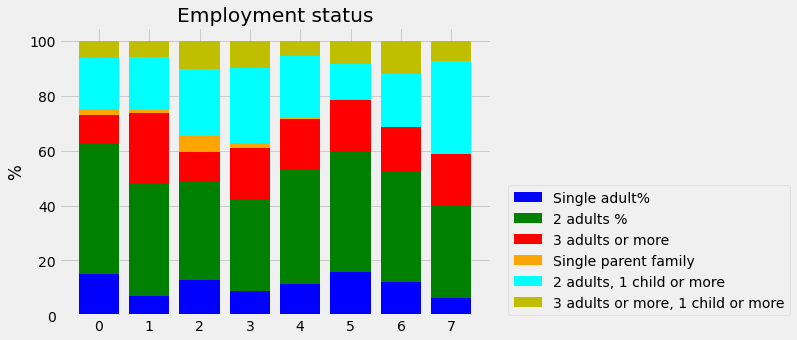

In [146]:
#household structure
pops = mrg('hh_struc').sum(axis=1)
single = mrg('hh_struc')['HHoldStruct_B02ID_1']/pops*100
two_adult = mrg('hh_struc')['HHoldStruct_B02ID_2']/pops*100
three_adult = mrg('hh_struc')['HHoldStruct_B02ID_3']/pops*100
single_parent_child = mrg('hh_struc')['HHoldStruct_B02ID_4']/pops*100
two_parents_child = mrg('hh_struc')['HHoldStruct_B02ID_5']/pops*100
three_adults_child = mrg('hh_struc')['HHoldStruct_B02ID_6']/pops*100

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = full.index


ax.bar(labels, single, color='b')
ax.bar(labels, two_adult,bottom=single, color='g')
ax.bar(labels, three_adult,bottom=two_adult+single, color='r')
ax.bar(labels, single_parent_child,bottom=two_adult+single+three_adult, color='orange')
ax.bar(labels, two_parents_child,bottom=two_adult+single+three_adult+\
       single_parent_child, color='cyan')
ax.bar(labels, three_adults_child,bottom=two_adult+single+\
       three_adult+single_parent_child+two_parents_child, color='y')

ax.set_ylabel('%')
ax.set_title('Employment status')

ax.legend(labels=['Single adult%', '2 adults %', '3 adults or more',\
                  'Single parent family','2 adults, 1 child or more',\
                  '3 adults or more, 1 child or more'],loc=(1.04, 0))
plt.show()

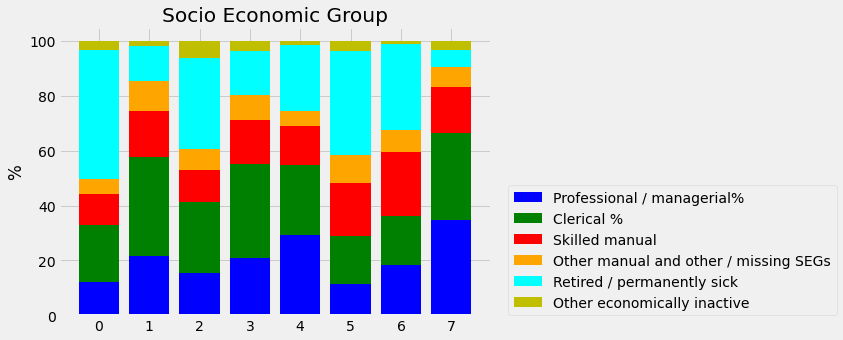

In [149]:
#social class 
pops = mrg('hh_socialclass').sum(axis=1)
single = mrg('hh_socialclass')['HRPSEGWorkStat_B01ID_1']/pops*100
two_adult = mrg('hh_socialclass')['HRPSEGWorkStat_B01ID_2']/pops*100
three_adult = mrg('hh_socialclass')['HRPSEGWorkStat_B01ID_3']/pops*100
single_parent_child = mrg('hh_socialclass')['HRPSEGWorkStat_B01ID_4']/pops*100
two_parents_child = mrg('hh_socialclass')['HRPSEGWorkStat_B01ID_5']/pops*100
three_adults_child = mrg('hh_socialclass')['HRPSEGWorkStat_B01ID_6']/pops*100

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = full.index


ax.bar(labels, single, color='b')
ax.bar(labels, two_adult,bottom=single, color='g')
ax.bar(labels, three_adult,bottom=two_adult+single, color='r')
ax.bar(labels, single_parent_child,bottom=two_adult+single+three_adult, color='orange')
ax.bar(labels, two_parents_child,bottom=two_adult+single+three_adult+\
       single_parent_child, color='cyan')
ax.bar(labels, three_adults_child,bottom=two_adult+single+\
       three_adult+single_parent_child+two_parents_child, color='y')

ax.set_ylabel('%')
ax.set_title('Socio Economic Group')

ax.legend(labels=['Professional / managerial%', 'Clerical %', 'Skilled manual',\
                  'Other manual and other / missing SEGs','Retired / permanently sick',\
                  'Other economically inactive'],loc=(1.04, 0))
plt.show()

In [150]:
socio.columns

Index(['Age_B04ID_4', 'Age_B04ID_5', 'Age_B04ID_6', 'Age_B04ID_7',
       'Age_B04ID_8', 'Age_B04ID_9', 'Sex_B01ID_1', 'Sex_B01ID_2', 'married',
       'not_married', 'IndIncome2002_B02ID_1', 'IndIncome2002_B02ID_2',
       'IndIncome2002_B02ID_3', 'fulltime', 'parttime', 'not_working',
       'HHIncome2002_B02ID_1', 'HHIncome2002_B02ID_2', 'HHIncome2002_B02ID_3',
       'HHoldStruct_B02ID_1', 'HHoldStruct_B02ID_2', 'HHoldStruct_B02ID_3',
       'HHoldStruct_B02ID_4', 'HHoldStruct_B02ID_5', 'HHoldStruct_B02ID_6',
       'hh_fulltime', 'hh_parttime', 'hh_not_working',
       'HRPSEGWorkStat_B01ID_1', 'HRPSEGWorkStat_B01ID_2',
       'HRPSEGWorkStat_B01ID_3', 'HRPSEGWorkStat_B01ID_4',
       'HRPSEGWorkStat_B01ID_5', 'HRPSEGWorkStat_B01ID_6',
       'Settlement2011EW_B03ID_1', 'Settlement2011EW_B03ID_2', 'label', 'AGE',
       'INCOME'],
      dtype='object')

In [ ]:
#mobility.corr().style.background_gradient(cmap='coolwarm')